<a href="https://colab.research.google.com/github/miltondp/k99_courses/blob/main/cis_522/classes/02_07-week4/W4D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 4 Part 1
# Optimization

__Instructor__: Lyle Ungar

__Content creator:__ Rongguang Wang

__Content reviewer:__ Pooja Consul, Ann-Katrin Reuel, Kausik Sivakumar, Jordan Matelsky


In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'miltondp' #@param {type:"string"}
my_pod = "Factorial Ferrets"  # @param ["Factorial Ferrets", "Causal Crows", "Recursive Roosters", "Bayesian Bighorns", "Probabilistic Pronghorns", "Hashing Hares", "Multiplicative Mustangs", "Curiosity Capybaras", "Subspace Salamanders"]
my_email = 'miltondp@gmail.com' #@param {type:"string"}
tutorial = 'W4D1'


# start timing
import time
try:t0;
except NameError: t0 = time.time()

---
# Intro: Optimization and why it matters


Video available at https://youtube.com/watch?v=cqQ7dVSYn7c


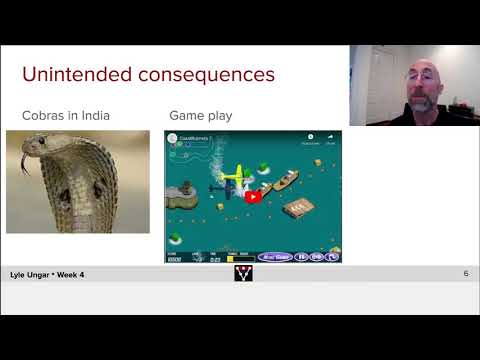

In [2]:
#@title Video : Introduction video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="cqQ7dVSYn7c", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

---
# Setup
Note that some of the code for today can take up to an hour to run. We have therefore "hidden" that code and shown the resulting outputs.

In [3]:
# imports
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import requests
import io
from urllib.request import urlopen


In [4]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

# plt.rcParams.update(plt.rcParamsDefault)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

---




# Section 0: Before we get to work...
# A cautionary tale
Generally speaking, when optimizing make sure that you :
- optimize for the right thing and 
- be aware of the potential unintended consequences that can arise from your optimization scheme

Consider the following example:

You are optimizing a food delivery service that will deliver 12 meals over a 3 hour evening period. Each person you deliver to will give you a rating of 1-3 stars, mostly based on whether the food is on time or late. Assume customers start at 3 stars and deduct one star for each quarter hour that the delivery is late. You have all 12 meals at hand (they are precooked, delivered cold for people to heat up) and it takes 15 minutes to deliver each meal.
On days that things go right, you’re perfectly on time with all meals. 

**Quiz Question 1:** If you get delayed by 15 minutes at the start of the night, what is an optimal strategy for maximizing the number of stars you get?

In [5]:
strategy = 'start with those that are closer first, so I minimize losing stars' #@param {type:"string"}

**Quiz Question 2:** What would be a better loss function?

In [6]:
loss_fn = 'average the starts given by customer instead of its sum' #@param {type:"string"}

## Objectives for this week

We show how gradient descent can be tweaked using minibatch, adaptive learning rate, and other techiniques to really speed up the optimization process, and hint at the theory behind it.

0.   Make sure to optimize the right thing!
1.   The optimization landscape; geometric intuition behind Stochastic Gradient Descent (SGD) and momentum
2.   Select batch size for minibatch gradient descent 
3.   Know batch normalization strengths and weaknesses

---
# Section 1: Why is optimization hard? 

Video available at https://youtube.com/watch?v=g0zOEcPix2w


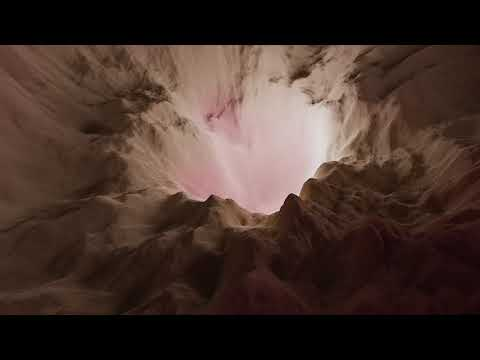

In [7]:
#@title Video: Example of an optimization landscape

try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="g0zOEcPix2w", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Ask yourself: Why is optimization hard? Think about what the optimization landscape can look like for more complex functions then take a look at the video and the interactive plot below to better understand why it is hard to find the global minima and not get stuck in a local minima.

[Interactive visualization](https://losslandscape.com/explorer)


Video available at https://youtube.com/watch?v=68VFZeWWe-s


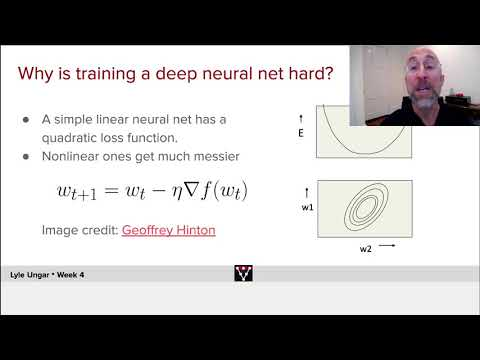

In [8]:
#@title Video : The difficulty of training a deep neural network
video = YouTubeVideo(id="68VFZeWWe-s", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

As you've just seen, the function we are looking to find a minimum of, can have a very complex landscape. 
  

In [9]:
#@markdown **Quiz Question 3:** Can you come up with some basic characteristics that we need for a good gradient descent algorithm ? 
characteristics_for_gd = "well, the video mentions that it should be fast and should converge to a good optimum (doesn't matter if it is not the global optimum)" #@param {type:"string"}

---
# Section 2: Minibatch stochastic gradient descent (SGD)

Video available at https://youtube.com/watch?v=l4n7BZjNbTI


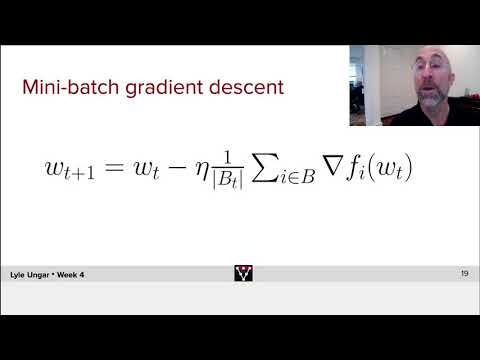

In [10]:
#@title Video: Minibatch

try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="l4n7BZjNbTI", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In stochastic gradient descent, we replace the actual gradient vector with a stochastic estimation of the gradient vector. Specifically for a neural network, the stochastic estimation uses the gradient of the loss for a single data point (single instance).

Given $f_i=l(x_i, y_i, w)$, the expected value of the $t$-th step of SGD is the same as the $t$-th step of full gradient descent.

$$\mathbb{E}[w_{t+1}]=w_t-\eta \mathbb{E}[\nabla f_i(w_t)]=w_t-\eta\nabla f(w_t)$$

where $i$ is chosen uniformly at random, thereby $f_i$ is a noisy but unbiased estimator of $f$.

$$w_{t+1}=w_t-\eta\nabla f_i(w_t)$$

We update the weights according to the gradient over $f_i$ (as opposed to the gradient over the total loss $f$).

SGD advantages:
*   The noise in the SGD update can prevent convergence to a bad (shallow) local minima.
*   It is drastically cheaper to compute (as you don’t go over all data points).


### Minibatching

Often we are able to make better use of our hardware by using mini batches instead of single instances. We compute the loss over a mini-batch -- a set of randomly selected instances instead of calculating it over just one instance. This reduces the noise in the step update.

Given the $t$th minibatch $B_t$ consisting of $k$ observations: 

$$w_{t+1}=w_t-\eta \frac{1}{|B_t|}\sum_{i\in B}\nabla f_i(w_t)$$


In [11]:
#@markdown **Quiz Question 4:** How would the plot of training error vs epochs differ for minibatch gradient descent when compared to stochastic gradient descent?
sgd_vs_minibtach_plot = 'if minibatching reduces noise compared with SGD, then the plot of training error would be smoother than SGD. That is, it would go down more consistently, whereas SGD would go down in one epoch, then maybe go up a little bit, go down again, etc.' #@param {type:"string"}

## Exercise 1: Finding the optimal minibatch size 

### Exercise 1.1

One of the main constraints of training deep neural networks is the relative limited size of GPU memory. Being able to quickly estimate if your minibatch size can be held in that memory will save you time and out-of-memory errors.

What do we need to store at training time? 
- outputs of intermediate layers (forward pass): 
- model parameters
- error signal at each neuron
- the gradient of parameters
plus any extra memory needed by optimizer (e.g. for momentum)




Fully connected layers
- #weights = #outputs x #inputs
- #biases = #outputs


This is dominated by the weights and their gradients. (You can confirm that there are far fewer node outputs than weights.) Assume we need to store the weights, their gradients and momentum, at 4 bytes/weight.  


In [12]:
#@markdown **Quiz Question 5:** How many megabytes is this for the model specified in exercise 1.2?

megabytes_1 = '(1 for each weight + 1 for their gradients + 1 for their momentum) * 4 bytes * (784 * 128 + 128 * 10)' #@param {type:"string"}

#@markdown **Quiz Question 6:** If we also store a gradient for every observation in a minibatch of size 50 (to allow parallel processing), how many megabytes will now be needed?

megabytes_2 = '50 obs * 4 bytes * (784 * 128 + 128 * 10)' #@param {type:"string"}


### Exercise 1.2

We find the optimal minibatch size using a 2-hidden layer nerual network on the hand-written digit classification dataset (MNIST). There are 10 classes (0 - 9) in the dataset. We use stochastic gradient descent (SGD) algorithm to optimize the training phase.

Plot test accuracy as a function of minibatch size (with constant wall time); explain the pattern.

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)
    
def main(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    acc_list, time_list = [], []
    start_time = time.time()
    for epoch in range(1, args['epochs'] + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        time_list.append(time.time()-start_time)
        acc = test(model, device, test_loader)
        acc_list.append(acc)

    return acc_list, time_list

Note: The training takes over 20 mins. Time for a break, grab a cup of coffee while you're waiting for the output :)

In [14]:
# @markdown ### Train (run me)
# Training settings
args = {'batch_size': 32,
        'test_batch_size': 1000,
        'epochs': 3,
        'lr': 0.01,
        'momentum': 0.9,
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

batch_size = [8, 16, 32, 64, 256, 512, 1024]
acc_dict = {}
test_acc = []

for i in range(len(batch_size)):
    args['batch_size'] = batch_size[i]
    acc, timer = main(args)
    acc_dict['acc'+str(batch_size[i])] = acc
    acc_dict['time'+str(batch_size[i])] = timer
    test_acc.append(acc[-1])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.212950
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.633358
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.387849
Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.146681
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.374804
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.176324
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.137902
Train Epoch: 1 [5600/60000 (9%)]	Loss: 0.165800
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.556258
Train Epoch: 1 [7200/60000 (12%)]	Loss: 0.226273
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.011656
Train Epoch: 1 [8800/60000 (15%)]	Loss: 1.092710
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.028158
Train Epoch: 1 [10400/60000 (17%)]	Loss: 0.230705
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.546691
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.198070
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.174880
Train Epoch: 1 [13600/60000 (23%)]	Loss: 0.493409
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.00105

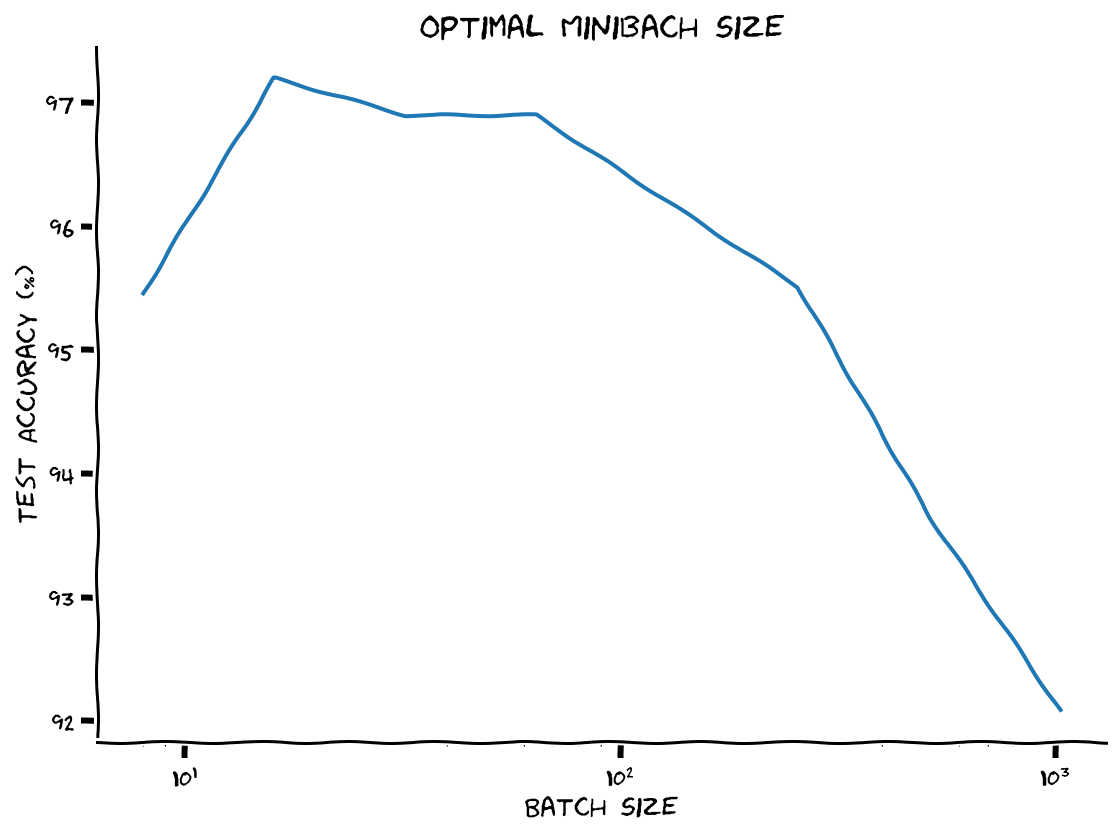

In [16]:
# @markdown ### Plot (run me)
with plt.xkcd():
    plt.plot(batch_size, test_acc, linewidth=2)
    plt.title('Optimal Minibach Size')
    plt.ylabel('Test Accuracy (%)')
    plt.xscale('log')
    plt.xlabel('Batch Size')
    plt.savefig('minibatch.png')
    plt.show()

In [15]:
#@markdown **Quiz Question 7:** How did the convergence speed vary with batch size? Why?
convergence_speed = 'by looking at the logs, it seems like the larger the batch size, the better the convergence speed' #@param {type:"string"}

---
# Section 3: Batch normalization

Video available at https://youtube.com/watch?v=FAnd9Ra7v-E


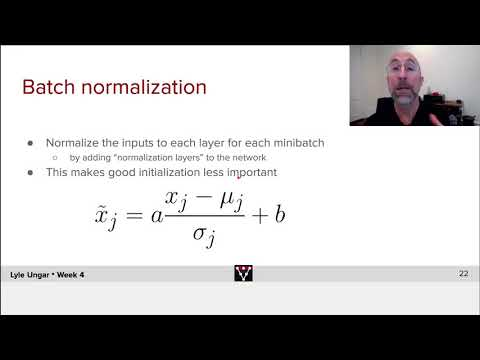

In [18]:
#@title Video: Batch Normalization

try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="FAnd9Ra7v-E", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Rather than improving the optimization algorithms, batch normalization improves the network structure itself by adding additional layers in between existing layers. The goal is to improve the optimization and generalization performance.

In neural networks, we typically alternate linear (weighted summation) operations with non-linear operations, the activation functions, such as ReLU. The most common practice is to put the normalization in between the linear layers and activation functions.

More formally, normalization is as follows:
$$\tilde x_j = a\frac{x_j-\mu_j}{\sigma_j}+b$$
where
*   $x_j$ is the output of a neuron or, equivalently, the input to the next layer,
*   $\tilde x_j$ is that same feature after being normalized ,
*   $\mu_j$ is the mean of the feature $x_j$ over the minibatch,
*   $\sigma_j$ is the estimate of the standard deviation of $x_j$ over the minibatch (with $\epsilon$ added, so we don't divide by zero),
*   $a$ is the learnable scaling factor,
*   $b$ is the learnable bias term.

Batch normalization tries to reduce the “internal covariate shift” between the training and testing data. Internal covariate shift is the change in the distribution of network activations due to the change in paramaters during training. In neural networks, the output of the first layer feeds into the second layer, the output of the second layer feeds into the third, and so on. When the parameters of a layer change, so does the distribution of inputs to subsequent layers. These shifts in input distributions can be problematic for neural networks, especially deep neural networks that could have a large number of layers. Batch normalization tries to mitigate this. You can check out [this](https://arxiv.org/abs/1502.03167) paper where the idea of mitigating internal covariance shift with batch normalization was first introduced. 


The advantages of BN are as follows:

*   Networks with normalization layers are easier to optimize, allowing for the use of larger learning rates, speeding up the training of neural networks.
*   The mean/std deviation estimates are noisy due to the randomness of the samples in batch. This extra “noise” sometimes results in better generalization. Normalization has a regularization effect.
*   Normalization reduces sensitivity to weight initialization.


In [26]:
#@markdown **Quiz Question 8:** Why do we need learnable parameters a and b for batch normalization? Why isn't the unit gaussian form sufficient?
batch_norm_ab = 'to allow the model to shift and scale a particular output to improve performance;' #@param {type:"string"}


## Exercise 2: The joys and perils of batch normalization

We implement 4 netowrks: 2-layer without batch norm, 2-layer without batch norm, 5-layer without batch norm, and 5-layer with batch norm separately to see how BN works in a shallow network and a deep one.

In [20]:
class BNShallowNet(nn.Module):
    def __init__(self):
        super(BNShallowNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class BNDeepNet(nn.Module):
    def __init__(self):
        super(BNDeepNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        output = F.log_softmax(x, dim=1)
        return output

class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        output = F.log_softmax(x, dim=1)
        return output

In [21]:
# @markdown ### Helper Functions (Run Me)
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    avg_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss /= len(train_loader.dataset)
    return avg_loss
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

def bn_eval(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)

    if args['net_type'] == 'Shallow':
        model = Net().to(device)
    elif args['net_type'] == 'BNShallow':
        model = BNShallowNet().to(device)
    elif args['net_type'] == 'Deep':
        model = DeepNet().to(device)
    elif args['net_type'] == 'BNDeep':
        model = BNDeepNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    train_list, test_list = [], []
    for epoch in range(1, args['epochs'] + 1):
        train_loss = train(args, model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        train_list.append(train_loss)
        test_list.append(test_loss)

    return train_list, test_list

The training takes over 20 mins. Again, time for a break :)

In [22]:
# @markdown ### Train function (Run me)
# Training settings
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'net_type': 'Net',
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

net = ['Shallow', 'BNShallow', 'Deep', 'BNDeep']
loss_dict = {}

for i in range(len(net)):
    args['net_type'] = net[i]
    train_loss, test_loss = bn_eval(args)
    loss_dict['train' + str(net[i])] = train_loss
    loss_dict['test' + str(net[i])] = test_loss

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282267
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.305935
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.222676
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.210134
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.246377
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.131048
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.221053
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.149199
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.078571
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.445500

Test set: Average loss: 0.1374, Accuracy: 9620/10000 (96.2000%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.072910
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.337304
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.080145
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.105342
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.253119
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.084582
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.167021
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.048025
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.153

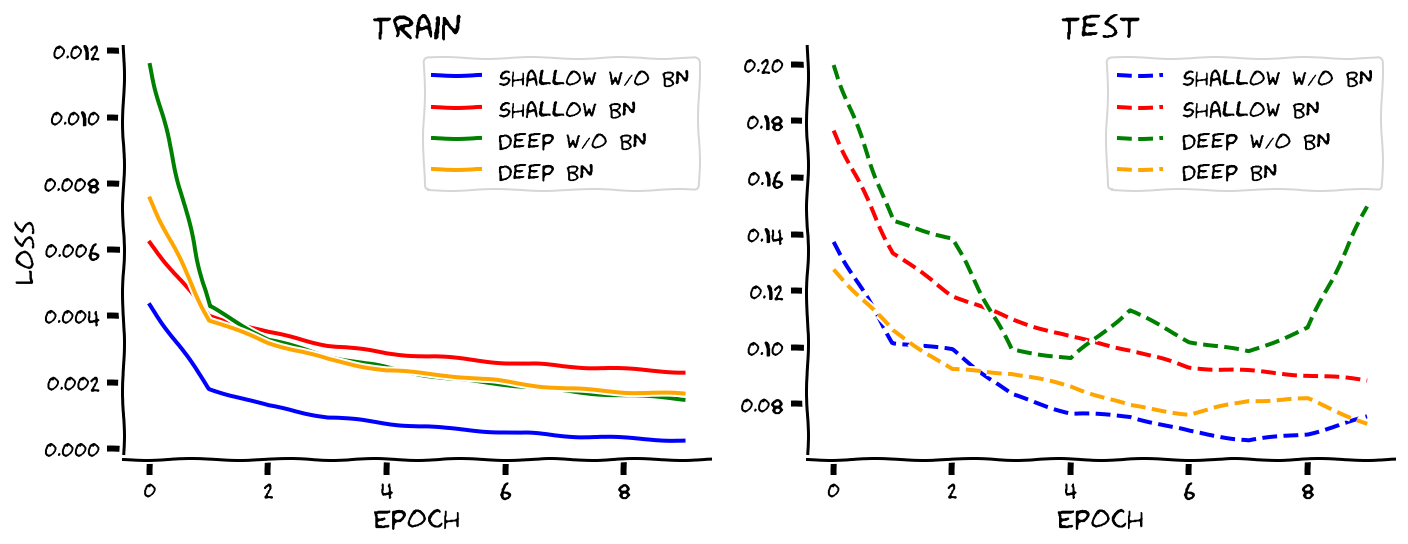

In [23]:
# @markdown ### Plot (run me)
with plt.xkcd():
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].plot(loss_dict['trainShallow'], label='Shallow w/o BN', color='b')
    axs[1].plot(loss_dict['testShallow'], label='Shallow w/o BN', color='b', linestyle='dashed')
    axs[0].plot(loss_dict['trainBNShallow'], label='Shallow BN', color='r')
    axs[1].plot(loss_dict['testBNShallow'], label='Shallow BN', color='r', linestyle='dashed')
    axs[0].plot(loss_dict['trainDeep'], label='Deep w/o BN', color='g')
    axs[1].plot(loss_dict['testDeep'], label='Deep w/o BN', color='g', linestyle='dashed')
    axs[0].plot(loss_dict['trainBNDeep'], label='Deep BN', color='orange')
    axs[1].plot(loss_dict['testBNDeep'], label='Deep BN', color='orange', linestyle='dashed')
    axs[0].set_title('Train')
    axs[1].set_title('Test')
    axs[0].set_ylabel('Loss')
    #plt.yscale('log')
    axs[0].set_xlabel('Epoch')
    axs[1].set_xlabel('Epoch')
    axs[0].legend()
    axs[1].legend()
    plt.show()

## Momentum 

Momentum in gradient descent is similar to the concept of momentum in physics. The optimization process resembles a ball rolling down the hill. Momentum keeps the ball moving in the same direction that it is already moving in. The gradient can be thought of as a force pushing the ball in some other direction.

<p align="center">
  <img width="460" height="300" src="https://miro.medium.com/max/640/1*i1Qc2E0TVlPHEKG7LepXgA.gif">
</p>

Mathematically it can be expressed as follows-
$$w_{t+1}=w_t-\eta (\nabla f(w_t) +\beta m_{t}) $$
$$m_{t+1}= \nabla f(w_t) +\beta m_{t}$$
or, equivalently
$$w_{t+1}= w_t -\eta\nabla f(w_t) +\beta (w_{t} -w_{t-1})$$

where
*   $m$ is the momentum (the running average of the past gradients, initialized at zero),
*   $\beta\in [0,1)$ is the damping factor, usually $0.9$ or $0.99$.



Let’s consider two extreme cases to understand this decay rate parameter better. If the decay rate is 0, then it is exactly the same as (vanilla) gradient descent (blue ball). If the decay rate is 1 (and provided that the learning rate is reasonably small), then it rocks back and forth endlessly like the frictionless ball we saw previously; you do not want that. Typically the decay rate is chosen around 0.8–0.9 — it’s like a surface with a little bit of friction so it eventually slows down and stops (purple ball).

<p align="center">
  <img width="460" height="300" src="https://miro.medium.com/max/800/1*zVi4ayX9u0MQQwa90CnxVg.gif">
</p>



Go check this out --> [Interactive view](https://distill.pub/2017/momentum/)

---
# Quiz

As you might have seen, the quiz questions are now dispersed throughout the notebook. This was requested by a few of you and we hope it makes it easier to answer questions as you go :) 

---
# Wrap up

## Submit responses

In [27]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

#@markdown If you have any issues with the submission form, please use this link and manually copy your answers there: https://airtable.com/shrUGZJaWo6SwgRTH

import time
import numpy as np
from IPython.display import IFrame
from urllib.parse import quote_plus

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, quote_plus(fields[key]) if isinstance(fields[key], str) else fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

times = [(t-t0) for t in [t1]]


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = ""
try: my_email;
except NameError: my_email = ""

 
try: strategy;
except NameError: strategy = "";
try: loss_fn;
except NameError: loss_fn = ""
try: characteristics_for_gd;
except NameError: characteristics_for_gd = ""
try: sgd_vs_minibtach_plot;
except NameError: sgd_vs_minibtach_plot = ""
try: megabytes_1;
except NameError: megabytes_1 = ""
try: megabytes_2;
except NameError: megabytes_2 = ""
try: convergence_speed;
except NameError: convergence_speed = False
try: batch_norm_ab;
except NameError: batch_norm_ab = ""




fields = {
    "pennkey": my_pennkey,
    "pod": my_pod, 
    "email": my_email,
    "tutorial": tutorial,
    "strategy": strategy, 
    "loss_fn": loss_fn, 
    "characteristics_for_gd": characteristics_for_gd,
    "sgd_vs_minibtach_plot": sgd_vs_minibtach_plot,
    "convergence_speed": convergence_speed,
    "batch_norm_ab": batch_norm_ab,
    "cumulative_times": times,
    "megabytes_1": megabytes_1,
    "megabytes_2": megabytes_2
}

src = "https://airtable.com/embed/shrUGZJaWo6SwgRTH?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


# Feedback

*   How could this session have been better?
*   How happy are you in your group?
*   How do you feel right now?

In [28]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))